In [1]:
import rlrom.utils as rlu
import polars as pl

2025-10-16 17:52:20.870805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 17:52:20.918840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 17:52:22.001719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical 

In [2]:
from rlrom.testers import RLTester

cfg_file= 'cfg0tr_ppo_specs.yml'
cfg = rlu.load_cfg(cfg_file)


loading field [ specs ] from STL file [ cartpole.stl ]
loading field [ ppo ] from YAML file [ cartpole_ppo.yml ]


# Collect existing training folders and load results

In [3]:
cfg_file= 'cfg0tr_ppo_specs.yml'
cfg = rlu.load_cfg(cfg_file)
df_all_training_files = rlu.get_df_all_training_files(cfg)
print(df_all_training_files.collect())

loading field [ specs ] from STL file [ cartpole.stl ]
loading field [ ppo ] from YAML file [ cartpole_ppo.yml ]
shape: (7, 4)
┌────────────┬─────┬─────────────────────────────────┬─────────────────────────────────┐
│ date       ┆ num ┆ training_files                  ┆ path                            │
│ ---        ┆ --- ┆ ---                             ┆ ---                             │
│ date       ┆ i64 ┆ object                          ┆ str                             │
╞════════════╪═════╪═════════════════════════════════╪═════════════════════════════════╡
│ 2025-10-16 ┆ 0   ┆ naive plan: (run LazyFrame.exp… ┆ /home/alex/workspace_local/rlr… │
│ 2025-10-16 ┆ 1   ┆ naive plan: (run LazyFrame.exp… ┆ /home/alex/workspace_local/rlr… │
│ 2025-10-16 ┆ 2   ┆ naive plan: (run LazyFrame.exp… ┆ /home/alex/workspace_local/rlr… │
│ 2025-10-16 ┆ 3   ┆ naive plan: (run LazyFrame.exp… ┆ /home/alex/workspace_local/rlr… │
│ 2025-10-16 ┆ 4   ┆ naive plan: (run LazyFrame.exp… ┆ /home/alex/worksp

Show the path for the first one. 

In [4]:
print(df_all_training_files.collect()['path'][0])

/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training0


To get the complete list of strings: 

In [5]:
print(df_all_training_files.collect()['path'].__array__())

['/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training0'
 '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training1'
 '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training2'
 '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training3'
 '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training4'
 '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training5'
 '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6']


In [6]:
df_training_files6 = df_all_training_files.collect().filter(pl.col('num')==6)['training_files'][0]
print(df_training_files6.collect())

shape: (21, 4)
┌────────┬────────────────────────────────┬───────────────────────┬────────────────────────────────┐
│ steps  ┆ res_files                      ┆ model_files           ┆ path                           │
│ ---    ┆ ---                            ┆ ---                   ┆ ---                            │
│ i64    ┆ str                            ┆ str                   ┆ str                            │
╞════════╪════════════════════════════════╪═══════════════════════╪════════════════════════════════╡
│ 10000  ┆ /home/alex/workspace_local/rlr ┆ model_step_10000.zip  ┆ /home/alex/workspace_local/rlr │
│        ┆ …                              ┆                       ┆ …                              │
│ 20000  ┆ /home/alex/workspace_local/rlr ┆ model_step_20000.zip  ┆ /home/alex/workspace_local/rlr │
│        ┆ …                              ┆                       ┆ …                              │
│ 30000  ┆ /home/alex/workspace_local/rlr ┆ model_step_30000.zip  ┆ /home/al

## Load file results

In [7]:
df_all_res = rlu.get_df_load_all_training_res(df_all_training_files)


In [8]:
print(df_all_res.collect().head())
print(df_all_res.collect().tail())


shape: (5, 10)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ steps ┆ model_file ┆ path       ┆ res        ┆ … ┆ cart_on_l ┆ phi_left_ ┆ reward_fo ┆ label     │
│ ---   ┆ s          ┆ ---        ┆ ---        ┆   ┆ eft       ┆ goal      ┆ rmulas    ┆ ---       │
│ i64   ┆ ---        ┆ str        ┆ struct[4]  ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str       │
│       ┆ str        ┆            ┆            ┆   ┆ struct[3] ┆ struct[2] ┆ struct[1] ┆           │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 10000 ┆ model_step ┆ /home/alex ┆ {{[0.0,    ┆ … ┆ {-0.25789 ┆ {-0.62916 ┆ {{0.0,-0. ┆ Training0 │
│       ┆ _10000.yml ┆ /workspace ┆ -0.312303, ┆   ┆ 5,0.0,-11 ┆ 8,0.0}    ┆ 257895,-1 ┆           │
│       ┆            ┆ _local/rlr ┆ …          ┆   ┆ .314293}  ┆           ┆ 1.314293} ┆           │
│       ┆            ┆ …          ┆ -0.58049]… ┆   ┆           ┆           ┆

# Plotting with Matplotlib

In [9]:
import rlrom.plots as rlp

df_all_res has all training data, with fields from res_all_ep expanded. 

In [10]:
df_enveloppe = rlu.get_df_mean_min_max_val(df_all_res, 'mean_ep_rew')

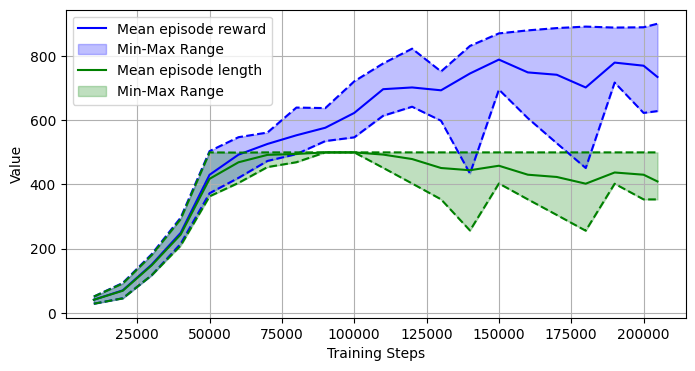

In [11]:
ax = rlp.plot_df_enveloppe(df_all_res, 'mean_ep_rew', label='Mean episode reward', linestyle='--', color='blue')
ax = rlp.plot_df_enveloppe(df_all_res, 'mean_ep_len', label='Mean episode length', linestyle='--', color='green', ax=ax)


For a formula, we need to unnest the result into init_rob and ratio_sat

In [14]:
phi = 'phi_left_goal'
df_res_phi = df_all_res.select('label', #training id 
                                    'steps',
                                    phi).unnest(phi)
print(df_res_phi.collect().head())

shape: (5, 4)
┌───────────┬───────┬───────────────┬────────────────┐
│ label     ┆ steps ┆ mean_init_rob ┆ ratio_init_sat │
│ ---       ┆ ---   ┆ ---           ┆ ---            │
│ str       ┆ i64   ┆ f64           ┆ f64            │
╞═══════════╪═══════╪═══════════════╪════════════════╡
│ Training0 ┆ 10000 ┆ -0.629168     ┆ 0.0            │
│ Training0 ┆ 20000 ┆ -0.624762     ┆ 0.1            │
│ Training0 ┆ 30000 ┆ -0.97792      ┆ 0.0            │
│ Training0 ┆ 40000 ┆ -0.699212     ┆ 0.0            │
│ Training0 ┆ 50000 ┆ -0.231577     ┆ 0.0            │
└───────────┴───────┴───────────────┴────────────────┘


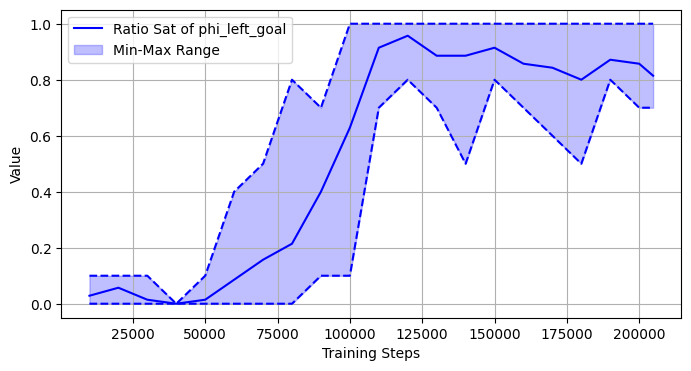

In [13]:
ax = rlp.plot_df_enveloppe(df_res_phi, 'ratio_init_sat', label='Ratio Sat of '+phi, linestyle='--', color='blue')

## Find best model

In [ ]:
import os, copy
from rlrom.testers import RLTester

In [15]:
find_max = pl.col('mean_ep_rew')==pl.col('mean_ep_rew').max()
df_res_max = df_all_res.filter(find_max)

In [16]:
print(df_res_max.collect().select('steps', 'label', 'path', 'mean_ep_rew'))

shape: (1, 4)
┌────────┬───────────┬─────────────────────────────────┬─────────────┐
│ steps  ┆ label     ┆ path                            ┆ mean_ep_rew │
│ ---    ┆ ---       ┆ ---                             ┆ ---         │
│ i64    ┆ str       ┆ str                             ┆ f64         │
╞════════╪═══════════╪═════════════════════════════════╪═════════════╡
│ 204800 ┆ Training6 ┆ /home/alex/workspace_local/rlr… ┆ 901.070098  │
└────────┴───────────┴─────────────────────────────────┴─────────────┘


# Re-test

In [10]:
import copy,os

def retest_models(df_training_files, num_ep):
    cfg_test = cfg['cfg_test']
    for r in df_training_files.collect().iter_rows(named=True):
        print(f'Retesting for step {r['steps']}, i.e., model {r['res_files']}')
        cfg_test['model_file']= os.path.join(r['path'],r['model_files'])
        cfg_test['res_file'] = r['res_files']        
        cfg_tmp = copy.deepcopy(cfg)  
        cfg_tmp = rlu.set_rec_cfg_field(cfg_tmp,cfg_test=cfg_test)
        cfg_tmp = rlu.set_rec_cfg_field(cfg_tmp,render_mode=None, num_ep=num_ep)
        T = RLTester(cfg_tmp)
        T.run_cfg_test()        
        

In [11]:
retest_models(df_training_files6,20)

Retesting for step 10000, i.e., model /home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/res_step_10000.yml
INFO: Loading model file  /home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/model_step_10000.zip
loading PPO model succeeded
..........|
..........|

Retesting for step 20000, i.e., model /home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/res_step_20000.yml
INFO: Loading model file  /home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/model_step_20000.zip
loading PPO model succeeded
..........|
..........|

Retesting for step 30000, i.e., model /home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/res_step_30000.yml
INFO: Loading model file  /home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/model_step_30000.zip
loading PPO model succeeded
..........|
..

In [19]:
best_model_path = df_res_max.collect()['path'][0]
best_step = df_res_max.collect()['steps'][0]
best_model_file = os.path.join(best_model_path, f'model_step_{str(best_step)}.zip')
print(best_model_file)

/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/model_step_204800.zip


In [ ]:
cfg_test = cfg['cfg_test']
cfg_test['model_file']= best_model_file
cfg_test['res_file'] = './best_test_result.yml'
cfg_tmp = copy.deepcopy(cfg)
cfg_tmp = rlu.set_rec_cfg_field(cfg_tmp,cfg_test=cfg_test)
cfg_tmp = rlu.set_rec_cfg_field(cfg_tmp,render_mode=None, num_ep=100)
T = RLTester(cfg_tmp)
Tres = T.run_cfg_test()


In [ ]:
from rlrom.testers import RLTester

model_file= '/home/alex/workspace_local/rlrom/examples/cartpole/models/ppo_specs_2025_10_16__training6/model_step_204800.zip'
cfg_test = cfg['cfg_test']
cfg_test['model_file']= model_file
cfg_test['res_file'] = './test_best_result.yml'
cfg_tmp = rlu.set_rec_cfg_field(cfg,render_mode='human', num_ep=1)
T=RLTester(cfg_tmp)
T.run_cfg_test()


# Plotting with plotly (Work in progress, interactive plots)

In [ ]:
import plotly.express as px

## One training,  episode lengths and rewards

In [ ]:

df0 = df_all_res.select('steps', 'mean_ep_len', 'mean_ep_rew', 'label').filter(pl.col('label')=='Training0').collect()

In [ ]:
print(df)

In [ ]:
fig = px.line(df0, x='steps', y = ['mean_ep_len', 'mean_ep_rew'])
fig.show()

## All training episode lens and rewards

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1,  subplot_titles=['Mean Episode Length', 'Mean Episode Reward'])

go1 = px.line(df_all_res.collect(), x='steps', y = 'mean_ep_len', color='label')
go2 = px.line(df_all_res.collect(), x='steps', y = 'mean_ep_rew', color='label')

fig.add_traces(go1.data, rows=1, cols=1)
fig.add_traces(go2.data, rows=2, cols=1)

fig.update_layout(height=600, title_text="Training Metrics")
fig.show()

## Adding specs

In [ ]:
phi = 'phi_left_goal'
df_phi = df_all_res.select('label','steps',phi).unnest(phi)

In [ ]:
fig=  px.line(df_phi.collect(), x='steps', y = 'ratio_init_sat', color='label')
fig.show()

In [ ]:
expr_min = lambda feature: pl.col(feature).list.min().name.suffix('_min')
expr_max = lambda feature: pl.col(feature).list.max().name.suffix('_max')
expr_mean = lambda feature: pl.col(feature).list.mean().name.suffix('_mean')

feature = 'mean_ep_len'
df = df_all_res.select('label','steps',feature)
df_enveloppe = df.group_by(pl.col('steps')).agg(pl.col(feature)
                        ).sort(pl.col('steps'))                        


print(df_group.collect().select(expr_min(feature), expr_mean(feature),expr_max(feature)))


In [ ]:
fig = px.line(df_phi.collect(), x='steps', y = 'ratio_init_sat', color='label')
fig.show()